In [1]:
import os
import sys 

import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle 
import stemflow

pd.set_option('display.max_columns', None)
# warnings.filterwarnings('ignore')


/Users/liyingnceas/anaconda3/envs/drnets/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from stemflow.model_selection import ST_train_test_split
from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor, Generate_Quadtree
from xgboost import XGBClassifier, XGBRegressor # remember to install xgboost if you use it as base model
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle


In [10]:
ebird_scientific_name = pd.read_csv(f'./eBird_data.csv')

In [11]:
ebird_scientific_name

,checklist_id,observer_id,sampling_event_identifier,scientific_name,observation_count,species_observed,state_code,locality_id,latitude,longitude,protocol_type,all_species_reported,observation_date,year,day_of_year,time_observations_started,duration_minutes,effort_distance_km,number_observers
0,S62453203,obsr1303678,S62453203,Accipiter cooperii,0.0,False,US-FL,L10005380,30.485660,-87.292123,Stationary,True,2019-12-19,2019,353,11.650000,5,0.000,1
1,S62453203,obsr1303678,S62453203,Accipiter striatus,0.0,False,US-FL,L10005380,30.485660,-87.292123,Stationary,True,2019-12-19,2019,353,11.650000,5,0.000,1
2,S62453203,obsr1303678,S62453203,Actitis macularius,0.0,False,US-FL,L10005380,30.485660,-87.292123,Stationary,True,2019-12-19,2019,353,11.650000,5,0.000,1
3,S62453203,obsr1303678,S62453203,Agapornis roseicollis,0.0,False,US-FL,L10005380,30.485660,-87.292123,Stationary,True,2019-12-19,2019,353,11.650000,5,0.000,1
4,S62453203,obsr1303678,S62453203,Agelaius phoeniceus,0.0,False,US-FL,L10005380,30.485660,-87.292123,Stationary,True,2019-12-19,2019,353,11.650000,5,0.000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46955925,G7629534,"obsr489096,obsr256527","S99866988,S99896090",Zenaida asiatica,0.0,False,US-MS,L3961801,30.400805,-88.968653,Traveling,True,2021-12-30,2021,364,11.133333,73,3.058,2
46955926,G7629534,"obsr489096,obsr256527","S99866988,S99896090",Zenaida macroura,4.0,True,US-MS,L3961801,30.400805,-88.968653,Traveling,True,2021-12-30,2021,364,11.133333,73,3.058,2
46955927,G7629534,"obsr489096,obsr256527","S99866988,S99896090",Zonotrichia albicollis,0.0,False,US-MS,L3961801,30.400805,-88.968653,Traveling,True,2021-12-30,2021,364,11.133333,73,3.058,2
46955928,G7629534,"obsr489096,obsr256527","S99866988,S99896090",Zonotrichia leucophrys,0.0,False,US-MS,L3961801,30.400805,-88.968653,Traveling,True,2021-12-30,2021,364,11.133333,73,3.058,2


In [28]:
# Check if there are any NaN values
if ebird_scientific_name.isna().any().any():
    print("There are still NaN values in the DataFrame.")
else:
    print("All NaN values have been handled.")

# Summary of missing values after processing
print("Summary of missing values after processing:")
print(ebird_scientific_name.isna().sum())

There are still NaN values in the DataFrame.
Summary of missing values after processing:
checklist_id                    0
observer_id                     0
sampling_event_identifier       0
scientific_name                 0
observation_count            9328
species_observed                0
state_code                      0
locality_id                     0
latitude                        0
longitude                       0
protocol_type                   0
all_species_reported            0
observation_date                0
year                            0
day_of_year                     0
time_observations_started       0
duration_minutes                0
effort_distance_km              0
number_observers                0
dtype: int64


In [12]:
# Assuming df is your original DataFrame
num_levels = ebird_scientific_name['scientific_name'].nunique()

print(f"Number of unique levels in 'scientific_name': {num_levels}")

Number of unique levels in 'scientific_name': 406


In [19]:
scientific_to_common = pd.read_csv("ebird-taxonomy.csv")
scientific_to_common = scientific_to_common[['scientific_name', 'common_name']]

In [20]:
ebird_common_name = pd.merge(ebird_scientific_name, scientific_to_common, on='scientific_name', how='left')


In [21]:
ebird_common_name

,checklist_id,observer_id,sampling_event_identifier,scientific_name,observation_count,species_observed,state_code,locality_id,latitude,longitude,protocol_type,all_species_reported,observation_date,year,day_of_year,time_observations_started,duration_minutes,effort_distance_km,number_observers,common_name
0,S62453203,obsr1303678,S62453203,Accipiter cooperii,0.0,False,US-FL,L10005380,30.485660,-87.292123,Stationary,True,2019-12-19,2019,353,11.650000,5,0.000,1,Cooper's Hawk
1,S62453203,obsr1303678,S62453203,Accipiter striatus,0.0,False,US-FL,L10005380,30.485660,-87.292123,Stationary,True,2019-12-19,2019,353,11.650000,5,0.000,1,Sharp-shinned Hawk
2,S62453203,obsr1303678,S62453203,Actitis macularius,0.0,False,US-FL,L10005380,30.485660,-87.292123,Stationary,True,2019-12-19,2019,353,11.650000,5,0.000,1,Spotted Sandpiper
3,S62453203,obsr1303678,S62453203,Agapornis roseicollis,0.0,False,US-FL,L10005380,30.485660,-87.292123,Stationary,True,2019-12-19,2019,353,11.650000,5,0.000,1,Rosy-faced Lovebird
4,S62453203,obsr1303678,S62453203,Agelaius phoeniceus,0.0,False,US-FL,L10005380,30.485660,-87.292123,Stationary,True,2019-12-19,2019,353,11.650000,5,0.000,1,Red-winged Blackbird
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46955925,G7629534,"obsr489096,obsr256527","S99866988,S99896090",Zenaida asiatica,0.0,False,US-MS,L3961801,30.400805,-88.968653,Traveling,True,2021-12-30,2021,364,11.133333,73,3.058,2,White-winged Dove
46955926,G7629534,"obsr489096,obsr256527","S99866988,S99896090",Zenaida macroura,4.0,True,US-MS,L3961801,30.400805,-88.968653,Traveling,True,2021-12-30,2021,364,11.133333,73,3.058,2,Mourning Dove
46955927,G7629534,"obsr489096,obsr256527","S99866988,S99896090",Zonotrichia albicollis,0.0,False,US-MS,L3961801,30.400805,-88.968653,Traveling,True,2021-12-30,2021,364,11.133333,73,3.058,2,White-throated Sparrow
46955928,G7629534,"obsr489096,obsr256527","S99866988,S99896090",Zonotrichia leucophrys,0.0,False,US-MS,L3961801,30.400805,-88.968653,Traveling,True,2021-12-30,2021,364,11.133333,73,3.058,2,White-crowned Sparrow


In [4]:
ebird

,locality_id,latitude.x,longitude.x,common_name,observation_count,species_observed,protocol_type,day_of_year,time_observations_started,duration_minutes,effort_distance_km,number_observers,year,barren,forest,fresh_marsh,fresh_woody_wetland,grassland,pasture,shore,shrub,urban,water,agriculture,salt_marsh,salt_woody_wetland,ocean,elevation_median,elevation_sd,northness_median,northness_sd,eastness_median,eastness_sd,slopeness_median,slopeness_sd,chl_mean,poc_mean,t_mean
0,L10005380,30.485660,-87.292123,Cooper's Hawk,0,0,0,353,11.65,5,0.0,1,2020,0.047685,0.126151,0.005803,0.065220,0.035322,0.022203,0.000126,0.009714,0.337959,0.009714,0.0,0.000000,0.000000,0.0,0.818953,0.259466,-0.131304,0.159421,0.032104,0.124195,0.751184,0.340208,0.433595,0.330567,0.461247
1,L10005380,30.485660,-87.292123,Sharp-shinned Hawk,0,0,0,353,11.65,5,0.0,1,2020,0.047685,0.126151,0.005803,0.065220,0.035322,0.022203,0.000126,0.009714,0.337959,0.009714,0.0,0.000000,0.000000,0.0,0.818953,0.259466,-0.131304,0.159421,0.032104,0.124195,0.751184,0.340208,0.433595,0.330567,0.461247
2,L10005380,30.485660,-87.292123,Spotted Sandpiper,0,0,0,353,11.65,5,0.0,1,2020,0.047685,0.126151,0.005803,0.065220,0.035322,0.022203,0.000126,0.009714,0.337959,0.009714,0.0,0.000000,0.000000,0.0,0.818953,0.259466,-0.131304,0.159421,0.032104,0.124195,0.751184,0.340208,0.433595,0.330567,0.461247
3,L10005380,30.485660,-87.292123,Rosy-faced Lovebird,0,0,0,353,11.65,5,0.0,1,2020,0.047685,0.126151,0.005803,0.065220,0.035322,0.022203,0.000126,0.009714,0.337959,0.009714,0.0,0.000000,0.000000,0.0,0.818953,0.259466,-0.131304,0.159421,0.032104,0.124195,0.751184,0.340208,0.433595,0.330567,0.461247
4,L10005380,30.485660,-87.292123,Red-winged Blackbird,0,0,0,353,11.65,5,0.0,1,2020,0.047685,0.126151,0.005803,0.065220,0.035322,0.022203,0.000126,0.009714,0.337959,0.009714,0.0,0.000000,0.000000,0.0,0.818953,0.259466,-0.131304,0.159421,0.032104,0.124195,0.751184,0.340208,0.433595,0.330567,0.461247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11930223,L13812456,30.397162,-87.060817,Black-billed Cuckoo,0,0,0,58,13.00,25,0.0,1,2020,0.004793,0.045781,0.002522,0.065078,0.000504,0.000504,0.000252,0.003279,0.131416,0.446084,0.0,0.008954,0.000252,0.0,0.768558,0.203688,0.158682,0.285381,0.004338,0.036178,0.504079,0.391641,0.161786,0.699321,0.242367
11930224,L13812456,30.397162,-87.060817,Northern Flicker,0,0,0,58,13.00,25,0.0,1,2020,0.004793,0.045781,0.002522,0.065078,0.000504,0.000504,0.000252,0.003279,0.131416,0.446084,0.0,0.008954,0.000252,0.0,0.768558,0.203688,0.158682,0.285381,0.004338,0.036178,0.504079,0.391641,0.161786,0.699321,0.242367
11930225,L13812456,30.397162,-87.060817,Northern Bobwhite,0,0,0,58,13.00,25,0.0,1,2020,0.004793,0.045781,0.002522,0.065078,0.000504,0.000504,0.000252,0.003279,0.131416,0.446084,0.0,0.008954,0.000252,0.0,0.768558,0.203688,0.158682,0.285381,0.004338,0.036178,0.504079,0.391641,0.161786,0.699321,0.242367
11930226,L13812456,30.397162,-87.060817,Rock Pigeon,0,0,0,58,13.00,25,0.0,1,2020,0.004793,0.045781,0.002522,0.065078,0.000504,0.000504,0.000252,0.003279,0.131416,0.446084,0.0,0.008954,0.000252,0.0,0.768558,0.203688,0.158682,0.285381,0.004338,0.036178,0.504079,0.391641,0.161786,0.699321,0.242367


In [30]:
# Assuming df is your original DataFrame
num_levels = ebird_common_name['common_name'].nunique()

print(f"Number of unique levels in 'common_name': {num_levels}")


Number of unique levels in 'common_name': 404


In [25]:
ebird_common_name.dropna()
if ebird_common_name.isna().any().any():
    print("There are still NaN values in the DataFrame.")
else:
    print("All NaN values have been handled.")
    
# Summary of missing values
print("Summary of missing values after processing:")
print(ebird_common_name.isna().sum())

There are still NaN values in the DataFrame.
Summary of missing values after processing:
checklist_id                      0
observer_id                       0
sampling_event_identifier         0
scientific_name                   0
observation_count              9328
species_observed                  0
state_code                        0
locality_id                       0
latitude                          0
longitude                         0
protocol_type                     0
all_species_reported              0
observation_date                  0
year                              0
day_of_year                       0
time_observations_started         0
duration_minutes                  0
effort_distance_km                0
number_observers                  0
common_name                  231310
dtype: int64


In [27]:
# Drop rows where 'common_name' has NaN values
ebird_common_name = ebird_common_name.dropna(subset=['common_name', 'observation_count'])

# Check if there are any NaN values remaining
if ebird_common_name.isna().any().any():
    print("There are still NaN values in the DataFrame.")
else:
    print("All NaN values have been handled.")

# Summary of missing values after processing
print("Summary of missing values after processing:")
print(ebird_common_name.isna().sum())


All NaN values have been handled.
Summary of missing values after processing:
checklist_id                 0
observer_id                  0
sampling_event_identifier    0
scientific_name              0
observation_count            0
species_observed             0
state_code                   0
locality_id                  0
latitude                     0
longitude                    0
protocol_type                0
all_species_reported         0
observation_date             0
year                         0
day_of_year                  0
time_observations_started    0
duration_minutes             0
effort_distance_km           0
number_observers             0
common_name                  0
dtype: int64


In [4]:
# Save the cleaned DataFrame to a CSV file
ebird_common_name.to_csv("cleaned_ebird_data.csv", index=False)


NameError: name 'ebird_common_name' is not defined

In [4]:
ebird_common_name = pd.read_csv("cleaned_ebird_data.csv")

In [6]:
ebird_common_name

,checklist_id,observer_id,sampling_event_identifier,scientific_name,observation_count,species_observed,state_code,locality_id,latitude,longitude,protocol_type,all_species_reported,observation_date,year,day_of_year,time_observations_started,duration_minutes,effort_distance_km,number_observers,common_name
0,S62453203,obsr1303678,S62453203,Accipiter cooperii,0.0,False,US-FL,L10005380,30.485660,-87.292123,Stationary,True,2019-12-19,2019,353,11.650000,5,0.000,1,Cooper's Hawk
1,S62453203,obsr1303678,S62453203,Accipiter striatus,0.0,False,US-FL,L10005380,30.485660,-87.292123,Stationary,True,2019-12-19,2019,353,11.650000,5,0.000,1,Sharp-shinned Hawk
2,S62453203,obsr1303678,S62453203,Actitis macularius,0.0,False,US-FL,L10005380,30.485660,-87.292123,Stationary,True,2019-12-19,2019,353,11.650000,5,0.000,1,Spotted Sandpiper
3,S62453203,obsr1303678,S62453203,Agapornis roseicollis,0.0,False,US-FL,L10005380,30.485660,-87.292123,Stationary,True,2019-12-19,2019,353,11.650000,5,0.000,1,Rosy-faced Lovebird
4,S62453203,obsr1303678,S62453203,Agelaius phoeniceus,0.0,False,US-FL,L10005380,30.485660,-87.292123,Stationary,True,2019-12-19,2019,353,11.650000,5,0.000,1,Red-winged Blackbird
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46715318,G7629534,"obsr489096,obsr256527","S99866988,S99896090",Zenaida asiatica,0.0,False,US-MS,L3961801,30.400805,-88.968653,Traveling,True,2021-12-30,2021,364,11.133333,73,3.058,2,White-winged Dove
46715319,G7629534,"obsr489096,obsr256527","S99866988,S99896090",Zenaida macroura,4.0,True,US-MS,L3961801,30.400805,-88.968653,Traveling,True,2021-12-30,2021,364,11.133333,73,3.058,2,Mourning Dove
46715320,G7629534,"obsr489096,obsr256527","S99866988,S99896090",Zonotrichia albicollis,0.0,False,US-MS,L3961801,30.400805,-88.968653,Traveling,True,2021-12-30,2021,364,11.133333,73,3.058,2,White-throated Sparrow
46715321,G7629534,"obsr489096,obsr256527","S99866988,S99896090",Zonotrichia leucophrys,0.0,False,US-MS,L3961801,30.400805,-88.968653,Traveling,True,2021-12-30,2021,364,11.133333,73,3.058,2,White-crowned Sparrow


In [57]:
ebird_common=ebird_common_name.drop(columns=['checklist_id', 'observer_id', 'sampling_event_identifier', "state_code", 'all_species_reported', 'scientific_name', 'species_observed'])
ebird_common

,observation_count,locality_id,latitude,longitude,protocol_type,observation_date,year,day_of_year,time_observations_started,duration_minutes,effort_distance_km,number_observers,common_name
0,0.0,L10005380,30.485660,-87.292123,Stationary,2019-12-19,2019,353,11.650000,5,0.000,1,Cooper's Hawk
1,0.0,L10005380,30.485660,-87.292123,Stationary,2019-12-19,2019,353,11.650000,5,0.000,1,Sharp-shinned Hawk
2,0.0,L10005380,30.485660,-87.292123,Stationary,2019-12-19,2019,353,11.650000,5,0.000,1,Spotted Sandpiper
3,0.0,L10005380,30.485660,-87.292123,Stationary,2019-12-19,2019,353,11.650000,5,0.000,1,Rosy-faced Lovebird
4,0.0,L10005380,30.485660,-87.292123,Stationary,2019-12-19,2019,353,11.650000,5,0.000,1,Red-winged Blackbird
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46715318,0.0,L3961801,30.400805,-88.968653,Traveling,2021-12-30,2021,364,11.133333,73,3.058,2,White-winged Dove
46715319,4.0,L3961801,30.400805,-88.968653,Traveling,2021-12-30,2021,364,11.133333,73,3.058,2,Mourning Dove
46715320,0.0,L3961801,30.400805,-88.968653,Traveling,2021-12-30,2021,364,11.133333,73,3.058,2,White-throated Sparrow
46715321,0.0,L3961801,30.400805,-88.968653,Traveling,2021-12-30,2021,364,11.133333,73,3.058,2,White-crowned Sparrow


In [5]:
ebird_common_occurance=ebird_common_name.drop(columns=['checklist_id', 'observer_id', 'sampling_event_identifier', "state_code", 'all_species_reported', 'scientific_name', 'observation_count'])


In [6]:
import pandas as pd

# Assuming df is your original DataFrame
# List of all the columns to keep (besides 'common_name' and 'observation_count')
index_columns = [
    'locality_id', 'latitude', 'longitude', 'protocol_type', 
    'day_of_year', 'time_observations_started', 'duration_minutes', 'effort_distance_km', 
    'number_observers', 'year'
]

# Create a pivot table
pivoted_df = ebird_common_occurance.pivot_table(
    index=index_columns,  # Use all columns as index to keep them unique for each locality_id
    columns='common_name',  # Create new columns from common_name
    values='species_observed',  # Values will be from observation_count
    aggfunc='sum',  # Sum observation counts for duplicates
    fill_value=0  # Fill NaN with 0 if no observations for a given common_name
)

# Flatten the multi-level column index to have simple column names
pivoted_df.columns = pivoted_df.columns.get_level_values(0)

# Reset index to turn locality_id and other columns back into regular columns
pivoted_df = pivoted_df.reset_index()

# View the pivoted DataFrame
pivoted_df



common_name,locality_id,latitude,longitude,protocol_type,day_of_year,time_observations_started,duration_minutes,effort_distance_km,number_observers,year,Acadian Flycatcher,Alder Flycatcher,Allen's Hummingbird,American Avocet,American Bittern,American Black Duck,American Coot,American Crow,American Flamingo,American Golden-Plover,American Goldfinch,American Kestrel,American Oystercatcher,American Pipit,American Redstart,American Robin,American White Pelican,American Wigeon,American Woodcock,Anhinga,Ash-throated Flycatcher,Bachman's Sparrow,Baird's Sandpiper,Bald Eagle,Baltimore Oriole,Band-rumped Storm-Petrel,Bank Swallow,Barn Swallow,Barred Owl,Bay-breasted Warbler,Bell's Vireo,Belted Kingfisher,Black Scoter,Black Skimmer,Black Swan,Black Tern,Black Vulture,Black-and-white Warbler,Black-bellied Plover,Black-bellied Whistling-Duck,Black-billed Cuckoo,Black-capped Vireo,Black-chinned Hummingbird,Black-crowned Night Heron,Black-headed Grosbeak,Black-headed Gull,Black-legged Kittiwake,Black-necked Stilt,Black-throated Blue Warbler,Black-throated Gray Warbler,Black-throated Green Warbler,Black-whiskered Vireo,Blackburnian Warbler,Blackpoll Warbler,Blue Grosbeak,Blue Jay,Blue-gray Gnatcatcher,Blue-headed Vireo,Blue-winged Teal,Blue-winged Warbler,Boat-tailed Grackle,Bobolink,Bonaparte's Gull,Brewer's Blackbird,Bridled Tern,Broad-billed Hummingbird,Broad-tailed Hummingbird,Broad-winged Hawk,Bronzed Cowbird,Brown Booby,Brown Creeper,Brown Noddy,Brown Pelican,Brown Thrasher,Brown-crested Flycatcher,Brown-headed Cowbird,Brown-headed Nuthatch,Budgerigar,Buff-bellied Hummingbird,Buff-breasted Sandpiper,Bufflehead,Bullock's Oriole,Burrowing Owl,Calliope Hummingbird,Canada Goose,Canada Warbler,Canvasback,Cape May Warbler,Carolina Chickadee,Carolina Wren,Caspian Tern,Cassin's Kingbird,Cave Swallow,Cedar Waxwing,Cerulean Warbler,Chestnut-sided Warbler,Chimney Swift,Chipping Sparrow,Chuck-will's-widow,Cinnamon Teal,Clapper Rail,Clay-colored Sparrow,Cliff Swallow,Common Gallinule,Common Goldeneye,Common Grackle,Common Ground Dove,Common Loon,Common Merganser,Common Nighthawk,Common Tern,Common Yellowthroat,Connecticut Warbler,Cooper's Hawk,Couch's Kingbird,Crested Caracara,Dark-eyed Junco,Dickcissel,Double-crested Cormorant,Downy Woodpecker,Dunlin,Eared Grebe,Eastern Bluebird,Eastern Kingbird,Eastern Meadowlark,Eastern Phoebe,Eastern Screech-Owl,Eastern Towhee,Eastern Whip-poor-will,Eastern Wood-Pewee,Elegant Tern,Eurasian Collared-Dove,European Herring Gull,European Starling,Evening Grosbeak,Field Sparrow,Fish Crow,Fork-tailed Flycatcher,Forster's Tern,Fox Sparrow,Franklin's Gull,Fulvous Whistling-Duck,Gadwall,Glaucous Gull,Glossy Ibis,Golden Eagle,Golden Pheasant,Golden-crowned Kinglet,Golden-winged Warbler,Grasshopper Sparrow,Gray Catbird,Gray Flycatcher,Gray Kingbird,Gray-cheeked Thrush,Graylag Goose,Great Black-backed Gull,Great Blue Heron,Great Cormorant,Great Crested Flycatcher,Great Egret,Great Horned Owl,Great Kiskadee,Great Shearwater,Great-tailed Grackle,Greater Scaup,Greater White-fronted Goose,Greater Yellowlegs,Green Heron,Green-winged Teal,Groove-billed Ani,Gull-billed Tern,Hairy Woodpecker,Harris's Sparrow,Helmeted Guineafowl,Henslow's Sparrow,Hermit Thrush,Hooded Merganser,Hooded Oriole,Hooded Warbler,Horned Grebe,Horned Lark,House Finch,House Sparrow,Hudsonian Godwit,Iceland Gull,Inca Dove,Indian Peafowl,Indigo Bunting,Kentucky Warbler,Killdeer,King Rail,Lapland Longspur,Lark Sparrow,Laughing Gull,LeConte's Sparrow,Least Flycatcher,Least Sandpiper,Least Tern,Lesser Black-backed Gull,Lesser Goldfinch,Lesser Scaup,Lesser Yellowlegs,Limpkin,Lincoln's Sparrow,Little Blue Heron,Loggerhead Shrike,Long-billed Curlew,Long-billed Dowitcher,Long-tailed Duck,Louisiana Waterthrush,MacGillivray's Warbler,Magnificent Frigatebird,Magnolia Warbler,Mallard,Marbled Godwit,Marsh Wren,Masked Booby,Merlin,Mississippi Kite,Monk Parakeet,Mottled Duck,Mourning Dove,Mourning Warbler,Muscovy Duck,Mute Swan,Nashville Warbler,Nelson's Sparrow,Neotropic C

In [69]:
pivoted_df.to_csv("all_species_occurance.csv")

In [70]:
pivoted_df = pd.read_csv("all_species_count.csv")

In [7]:
habitat= pd.read_csv("pland_elev_north_east_slope_ocean_chl_poc_t_trange_3km.csv")

#habitat = habitat.drop(columns=['t_sd', 'trange_sd']) #too many NA in these two columns

In [8]:
ebird_common_habitat = pd.merge(pivoted_df, habitat, on='locality_id', how='left')
ebird_common_habitat

,locality_id,latitude_x,longitude_x,protocol_type,day_of_year,time_observations_started,duration_minutes,effort_distance_km,number_observers,year_x,Acadian Flycatcher,Alder Flycatcher,Allen's Hummingbird,American Avocet,American Bittern,American Black Duck,American Coot,American Crow,American Flamingo,American Golden-Plover,American Goldfinch,American Kestrel,American Oystercatcher,American Pipit,American Redstart,American Robin,American White Pelican,American Wigeon,American Woodcock,Anhinga,Ash-throated Flycatcher,Bachman's Sparrow,Baird's Sandpiper,Bald Eagle,Baltimore Oriole,Band-rumped Storm-Petrel,Bank Swallow,Barn Swallow,Barred Owl,Bay-breasted Warbler,Bell's Vireo,Belted Kingfisher,Black Scoter,Black Skimmer,Black Swan,Black Tern,Black Vulture,Black-and-white Warbler,Black-bellied Plover,Black-bellied Whistling-Duck,Black-billed Cuckoo,Black-capped Vireo,Black-chinned Hummingbird,Black-crowned Night Heron,Black-headed Grosbeak,Black-headed Gull,Black-legged Kittiwake,Black-necked Stilt,Black-throated Blue Warbler,Black-throated Gray Warbler,Black-throated Green Warbler,Black-whiskered Vireo,Blackburnian Warbler,Blackpoll Warbler,Blue Grosbeak,Blue Jay,Blue-gray Gnatcatcher,Blue-headed Vireo,Blue-winged Teal,Blue-winged Warbler,Boat-tailed Grackle,Bobolink,Bonaparte's Gull,Brewer's Blackbird,Bridled Tern,Broad-billed Hummingbird,Broad-tailed Hummingbird,Broad-winged Hawk,Bronzed Cowbird,Brown Booby,Brown Creeper,Brown Noddy,Brown Pelican,Brown Thrasher,Brown-crested Flycatcher,Brown-headed Cowbird,Brown-headed Nuthatch,Budgerigar,Buff-bellied Hummingbird,Buff-breasted Sandpiper,Bufflehead,Bullock's Oriole,Burrowing Owl,Calliope Hummingbird,Canada Goose,Canada Warbler,Canvasback,Cape May Warbler,Carolina Chickadee,Carolina Wren,Caspian Tern,Cassin's Kingbird,Cave Swallow,Cedar Waxwing,Cerulean Warbler,Chestnut-sided Warbler,Chimney Swift,Chipping Sparrow,Chuck-will's-widow,Cinnamon Teal,Clapper Rail,Clay-colored Sparrow,Cliff Swallow,Common Gallinule,Common Goldeneye,Common Grackle,Common Ground Dove,Common Loon,Common Merganser,Common Nighthawk,Common Tern,Common Yellowthroat,Connecticut Warbler,Cooper's Hawk,Couch's Kingbird,Crested Caracara,Dark-eyed Junco,Dickcissel,Double-crested Cormorant,Downy Woodpecker,Dunlin,Eared Grebe,Eastern Bluebird,Eastern Kingbird,Eastern Meadowlark,Eastern Phoebe,Eastern Screech-Owl,Eastern Towhee,Eastern Whip-poor-will,Eastern Wood-Pewee,Elegant Tern,Eurasian Collared-Dove,European Herring Gull,European Starling,Evening Grosbeak,Field Sparrow,Fish Crow,Fork-tailed Flycatcher,Forster's Tern,Fox Sparrow,Franklin's Gull,Fulvous Whistling-Duck,Gadwall,Glaucous Gull,Glossy Ibis,Golden Eagle,Golden Pheasant,Golden-crowned Kinglet,Golden-winged Warbler,Grasshopper Sparrow,Gray Catbird,Gray Flycatcher,Gray Kingbird,Gray-cheeked Thrush,Graylag Goose,Great Black-backed Gull,Great Blue Heron,Great Cormorant,Great Crested Flycatcher,Great Egret,Great Horned Owl,Great Kiskadee,Great Shearwater,Great-tailed Grackle,Greater Scaup,Greater White-fronted Goose,Greater Yellowlegs,Green Heron,Green-winged Teal,Groove-billed Ani,Gull-billed Tern,Hairy Woodpecker,Harris's Sparrow,Helmeted Guineafowl,Henslow's Sparrow,Hermit Thrush,Hooded Merganser,Hooded Oriole,Hooded Warbler,Horned Grebe,Horned Lark,House Finch,House Sparrow,Hudsonian Godwit,Iceland Gull,Inca Dove,Indian Peafowl,Indigo Bunting,Kentucky Warbler,Killdeer,King Rail,Lapland Longspur,Lark Sparrow,Laughing Gull,LeConte's Sparrow,Least Flycatcher,Least Sandpiper,Least Tern,Lesser Black-backed Gull,Lesser Goldfinch,Lesser Scaup,Lesser Yellowlegs,Limpkin,Lincoln's Sparrow,Little Blue Heron,Loggerhead Shrike,Long-billed Curlew,Long-billed Dowitcher,Long-tailed Duck,Louisiana Waterthrush,MacGillivray's Warbler,Magnificent Frigatebird,Magnolia Warbler,Mallard,Marbled Godwit,Marsh Wren,Masked Booby,Merlin,Mississippi Kite,Monk Parakeet,Mottled Duck,Mourning Dove,Mourning Warbler,Muscovy Duck,Mute Swan,Nashville Warbler,Nelson's Sparrow,Neotropic Cormor

In [9]:
ebird_common_habitat = ebird_common_habitat.drop(columns=['latitude_y', 'longitude_y', 'year_y'])

In [10]:
ebird_common_habitat.rename(columns={'latitude_x': 'latitude', 'longitude_x': 'longitude', 'year_x': 'year'}, inplace=True)


In [11]:
ebird_common_habitat

,locality_id,latitude,longitude,protocol_type,day_of_year,time_observations_started,duration_minutes,effort_distance_km,number_observers,year,Acadian Flycatcher,Alder Flycatcher,Allen's Hummingbird,American Avocet,American Bittern,American Black Duck,American Coot,American Crow,American Flamingo,American Golden-Plover,American Goldfinch,American Kestrel,American Oystercatcher,American Pipit,American Redstart,American Robin,American White Pelican,American Wigeon,American Woodcock,Anhinga,Ash-throated Flycatcher,Bachman's Sparrow,Baird's Sandpiper,Bald Eagle,Baltimore Oriole,Band-rumped Storm-Petrel,Bank Swallow,Barn Swallow,Barred Owl,Bay-breasted Warbler,Bell's Vireo,Belted Kingfisher,Black Scoter,Black Skimmer,Black Swan,Black Tern,Black Vulture,Black-and-white Warbler,Black-bellied Plover,Black-bellied Whistling-Duck,Black-billed Cuckoo,Black-capped Vireo,Black-chinned Hummingbird,Black-crowned Night Heron,Black-headed Grosbeak,Black-headed Gull,Black-legged Kittiwake,Black-necked Stilt,Black-throated Blue Warbler,Black-throated Gray Warbler,Black-throated Green Warbler,Black-whiskered Vireo,Blackburnian Warbler,Blackpoll Warbler,Blue Grosbeak,Blue Jay,Blue-gray Gnatcatcher,Blue-headed Vireo,Blue-winged Teal,Blue-winged Warbler,Boat-tailed Grackle,Bobolink,Bonaparte's Gull,Brewer's Blackbird,Bridled Tern,Broad-billed Hummingbird,Broad-tailed Hummingbird,Broad-winged Hawk,Bronzed Cowbird,Brown Booby,Brown Creeper,Brown Noddy,Brown Pelican,Brown Thrasher,Brown-crested Flycatcher,Brown-headed Cowbird,Brown-headed Nuthatch,Budgerigar,Buff-bellied Hummingbird,Buff-breasted Sandpiper,Bufflehead,Bullock's Oriole,Burrowing Owl,Calliope Hummingbird,Canada Goose,Canada Warbler,Canvasback,Cape May Warbler,Carolina Chickadee,Carolina Wren,Caspian Tern,Cassin's Kingbird,Cave Swallow,Cedar Waxwing,Cerulean Warbler,Chestnut-sided Warbler,Chimney Swift,Chipping Sparrow,Chuck-will's-widow,Cinnamon Teal,Clapper Rail,Clay-colored Sparrow,Cliff Swallow,Common Gallinule,Common Goldeneye,Common Grackle,Common Ground Dove,Common Loon,Common Merganser,Common Nighthawk,Common Tern,Common Yellowthroat,Connecticut Warbler,Cooper's Hawk,Couch's Kingbird,Crested Caracara,Dark-eyed Junco,Dickcissel,Double-crested Cormorant,Downy Woodpecker,Dunlin,Eared Grebe,Eastern Bluebird,Eastern Kingbird,Eastern Meadowlark,Eastern Phoebe,Eastern Screech-Owl,Eastern Towhee,Eastern Whip-poor-will,Eastern Wood-Pewee,Elegant Tern,Eurasian Collared-Dove,European Herring Gull,European Starling,Evening Grosbeak,Field Sparrow,Fish Crow,Fork-tailed Flycatcher,Forster's Tern,Fox Sparrow,Franklin's Gull,Fulvous Whistling-Duck,Gadwall,Glaucous Gull,Glossy Ibis,Golden Eagle,Golden Pheasant,Golden-crowned Kinglet,Golden-winged Warbler,Grasshopper Sparrow,Gray Catbird,Gray Flycatcher,Gray Kingbird,Gray-cheeked Thrush,Graylag Goose,Great Black-backed Gull,Great Blue Heron,Great Cormorant,Great Crested Flycatcher,Great Egret,Great Horned Owl,Great Kiskadee,Great Shearwater,Great-tailed Grackle,Greater Scaup,Greater White-fronted Goose,Greater Yellowlegs,Green Heron,Green-winged Teal,Groove-billed Ani,Gull-billed Tern,Hairy Woodpecker,Harris's Sparrow,Helmeted Guineafowl,Henslow's Sparrow,Hermit Thrush,Hooded Merganser,Hooded Oriole,Hooded Warbler,Horned Grebe,Horned Lark,House Finch,House Sparrow,Hudsonian Godwit,Iceland Gull,Inca Dove,Indian Peafowl,Indigo Bunting,Kentucky Warbler,Killdeer,King Rail,Lapland Longspur,Lark Sparrow,Laughing Gull,LeConte's Sparrow,Least Flycatcher,Least Sandpiper,Least Tern,Lesser Black-backed Gull,Lesser Goldfinch,Lesser Scaup,Lesser Yellowlegs,Limpkin,Lincoln's Sparrow,Little Blue Heron,Loggerhead Shrike,Long-billed Curlew,Long-billed Dowitcher,Long-tailed Duck,Louisiana Waterthrush,MacGillivray's Warbler,Magnificent Frigatebird,Magnolia Warbler,Mallard,Marbled Godwit,Marsh Wren,Masked Booby,Merlin,Mississippi Kite,Monk Parakeet,Mottled Duck,Mourning Dove,Mourning Warbler,Muscovy Duck,Mute Swan,Nashville Warbler,Nelson's Sparrow,Neotropic Cormorant,No

In [17]:
# Move columns 4 to 408 (index 3 to 407) to the back
columns_to_move = ebird_common_habitat.columns[11:414]  # Select columns by index (4th to 408th columns)
remaining_columns = ebird_common_habitat.columns[:11].tolist() + ebird_common_habitat.columns[414:].tolist()  # Keep other columns

# Reorder the DataFrame: remaining columns first, then the selected range
df = ebird_common_habitat[remaining_columns + columns_to_move.tolist()]

# View the updated column order
print(df.columns)


Index(['locality_id', 'latitude', 'longitude', 'protocol_type', 'day_of_year',
       'time_observations_started', 'duration_minutes', 'effort_distance_km',
       'number_observers', 'year',
       ...
       'Yellow-bellied Flycatcher', 'Yellow-bellied Sapsucker',
       'Yellow-billed Cuckoo', 'Yellow-breasted Chat',
       'Yellow-crowned Night Heron', 'Yellow-green Vireo',
       'Yellow-headed Blackbird', 'Yellow-rumped Warbler',
       'Yellow-throated Vireo', 'Yellow-throated Warbler'],
      dtype='object', length=441)


In [18]:
# Replace 'static' with 0 and 'traveling' with 1
df['protocol_type'] = df['protocol_type'].replace({'Stationary': 0, 'Traveling': 1})
# Convert True/False to 1/0
df

,locality_id,latitude,longitude,protocol_type,day_of_year,time_observations_started,duration_minutes,effort_distance_km,number_observers,year,Acadian Flycatcher,barren,forest,fresh_marsh,fresh_woody_wetland,grassland,pasture,shore,shrub,urban,water,agriculture,salt_marsh,salt_woody_wetland,ocean,ocean_fact,elevation_median,elevation_sd,northness_median,northness_sd,eastness_median,eastness_sd,slopeness_median,slopeness_sd,t_mean,trange_mean,poc_mean,chl_mean,Alder Flycatcher,Allen's Hummingbird,American Avocet,American Bittern,American Black Duck,American Coot,American Crow,American Flamingo,American Golden-Plover,American Goldfinch,American Kestrel,American Oystercatcher,American Pipit,American Redstart,American Robin,American White Pelican,American Wigeon,American Woodcock,Anhinga,Ash-throated Flycatcher,Bachman's Sparrow,Baird's Sandpiper,Bald Eagle,Baltimore Oriole,Band-rumped Storm-Petrel,Bank Swallow,Barn Swallow,Barred Owl,Bay-breasted Warbler,Bell's Vireo,Belted Kingfisher,Black Scoter,Black Skimmer,Black Swan,Black Tern,Black Vulture,Black-and-white Warbler,Black-bellied Plover,Black-bellied Whistling-Duck,Black-billed Cuckoo,Black-capped Vireo,Black-chinned Hummingbird,Black-crowned Night Heron,Black-headed Grosbeak,Black-headed Gull,Black-legged Kittiwake,Black-necked Stilt,Black-throated Blue Warbler,Black-throated Gray Warbler,Black-throated Green Warbler,Black-whiskered Vireo,Blackburnian Warbler,Blackpoll Warbler,Blue Grosbeak,Blue Jay,Blue-gray Gnatcatcher,Blue-headed Vireo,Blue-winged Teal,Blue-winged Warbler,Boat-tailed Grackle,Bobolink,Bonaparte's Gull,Brewer's Blackbird,Bridled Tern,Broad-billed Hummingbird,Broad-tailed Hummingbird,Broad-winged Hawk,Bronzed Cowbird,Brown Booby,Brown Creeper,Brown Noddy,Brown Pelican,Brown Thrasher,Brown-crested Flycatcher,Brown-headed Cowbird,Brown-headed Nuthatch,Budgerigar,Buff-bellied Hummingbird,Buff-breasted Sandpiper,Bufflehead,Bullock's Oriole,Burrowing Owl,Calliope Hummingbird,Canada Goose,Canada Warbler,Canvasback,Cape May Warbler,Carolina Chickadee,Carolina Wren,Caspian Tern,Cassin's Kingbird,Cave Swallow,Cedar Waxwing,Cerulean Warbler,Chestnut-sided Warbler,Chimney Swift,Chipping Sparrow,Chuck-will's-widow,Cinnamon Teal,Clapper Rail,Clay-colored Sparrow,Cliff Swallow,Common Gallinule,Common Goldeneye,Common Grackle,Common Ground Dove,Common Loon,Common Merganser,Common Nighthawk,Common Tern,Common Yellowthroat,Connecticut Warbler,Cooper's Hawk,Couch's Kingbird,Crested Caracara,Dark-eyed Junco,Dickcissel,Double-crested Cormorant,Downy Woodpecker,Dunlin,Eared Grebe,Eastern Bluebird,Eastern Kingbird,Eastern Meadowlark,Eastern Phoebe,Eastern Screech-Owl,Eastern Towhee,Eastern Whip-poor-will,Eastern Wood-Pewee,Elegant Tern,Eurasian Collared-Dove,European Herring Gull,European Starling,Evening Grosbeak,Field Sparrow,Fish Crow,Fork-tailed Flycatcher,Forster's Tern,Fox Sparrow,Franklin's Gull,Fulvous Whistling-Duck,Gadwall,Glaucous Gull,Glossy Ibis,Golden Eagle,Golden Pheasant,Golden-crowned Kinglet,Golden-winged Warbler,Grasshopper Sparrow,Gray Catbird,Gray Flycatcher,Gray Kingbird,Gray-cheeked Thrush,Graylag Goose,Great Black-backed Gull,Great Blue Heron,Great Cormorant,Great Crested Flycatcher,Great Egret,Great Horned Owl,Great Kiskadee,Great Shearwater,Great-tailed Grackle,Greater Scaup,Greater White-fronted Goose,Greater Yellowlegs,Green Heron,Green-winged Teal,Groove-billed Ani,Gull-billed Tern,Hairy Woodpecker,Harris's Sparrow,Helmeted Guineafowl,Henslow's Sparrow,Hermit Thrush,Hooded Merganser,Hooded Oriole,Hooded Warbler,Horned Grebe,Horned Lark,House Finch,House Sparrow,Hudsonian Godwit,Iceland Gull,Inca Dove,Indian Peafowl,Indigo Bunting,Kentucky Warbler,Killdeer,King Rail,Lapland Longspur,Lark Sparrow,Laughing Gull,LeConte's Sparrow,Least Flycatcher,Least Sandpiper,Least Tern,Lesser Black-backed Gull,Lesser Goldfinch,Lesser Scaup,Lesser Yellowlegs,Limpkin,Lincoln's Sparrow,Little Blue Heron,Loggerhead Shrike,Long-billed Curlew,Long-billed Dowitcher,Long-taile

In [14]:
df = df.iloc[:, 1:]


In [22]:
df.iloc[:, 37:]

,chl_mean,Alder Flycatcher,Allen's Hummingbird,American Avocet,American Bittern,American Black Duck,American Coot,American Crow,American Flamingo,American Golden-Plover,American Goldfinch,American Kestrel,American Oystercatcher,American Pipit,American Redstart,American Robin,American White Pelican,American Wigeon,American Woodcock,Anhinga,Ash-throated Flycatcher,Bachman's Sparrow,Baird's Sandpiper,Bald Eagle,Baltimore Oriole,Band-rumped Storm-Petrel,Bank Swallow,Barn Swallow,Barred Owl,Bay-breasted Warbler,Bell's Vireo,Belted Kingfisher,Black Scoter,Black Skimmer,Black Swan,Black Tern,Black Vulture,Black-and-white Warbler,Black-bellied Plover,Black-bellied Whistling-Duck,Black-billed Cuckoo,Black-capped Vireo,Black-chinned Hummingbird,Black-crowned Night Heron,Black-headed Grosbeak,Black-headed Gull,Black-legged Kittiwake,Black-necked Stilt,Black-throated Blue Warbler,Black-throated Gray Warbler,Black-throated Green Warbler,Black-whiskered Vireo,Blackburnian Warbler,Blackpoll Warbler,Blue Grosbeak,Blue Jay,Blue-gray Gnatcatcher,Blue-headed Vireo,Blue-winged Teal,Blue-winged Warbler,Boat-tailed Grackle,Bobolink,Bonaparte's Gull,Brewer's Blackbird,Bridled Tern,Broad-billed Hummingbird,Broad-tailed Hummingbird,Broad-winged Hawk,Bronzed Cowbird,Brown Booby,Brown Creeper,Brown Noddy,Brown Pelican,Brown Thrasher,Brown-crested Flycatcher,Brown-headed Cowbird,Brown-headed Nuthatch,Budgerigar,Buff-bellied Hummingbird,Buff-breasted Sandpiper,Bufflehead,Bullock's Oriole,Burrowing Owl,Calliope Hummingbird,Canada Goose,Canada Warbler,Canvasback,Cape May Warbler,Carolina Chickadee,Carolina Wren,Caspian Tern,Cassin's Kingbird,Cave Swallow,Cedar Waxwing,Cerulean Warbler,Chestnut-sided Warbler,Chimney Swift,Chipping Sparrow,Chuck-will's-widow,Cinnamon Teal,Clapper Rail,Clay-colored Sparrow,Cliff Swallow,Common Gallinule,Common Goldeneye,Common Grackle,Common Ground Dove,Common Loon,Common Merganser,Common Nighthawk,Common Tern,Common Yellowthroat,Connecticut Warbler,Cooper's Hawk,Couch's Kingbird,Crested Caracara,Dark-eyed Junco,Dickcissel,Double-crested Cormorant,Downy Woodpecker,Dunlin,Eared Grebe,Eastern Bluebird,Eastern Kingbird,Eastern Meadowlark,Eastern Phoebe,Eastern Screech-Owl,Eastern Towhee,Eastern Whip-poor-will,Eastern Wood-Pewee,Elegant Tern,Eurasian Collared-Dove,European Herring Gull,European Starling,Evening Grosbeak,Field Sparrow,Fish Crow,Fork-tailed Flycatcher,Forster's Tern,Fox Sparrow,Franklin's Gull,Fulvous Whistling-Duck,Gadwall,Glaucous Gull,Glossy Ibis,Golden Eagle,Golden Pheasant,Golden-crowned Kinglet,Golden-winged Warbler,Grasshopper Sparrow,Gray Catbird,Gray Flycatcher,Gray Kingbird,Gray-cheeked Thrush,Graylag Goose,Great Black-backed Gull,Great Blue Heron,Great Cormorant,Great Crested Flycatcher,Great Egret,Great Horned Owl,Great Kiskadee,Great Shearwater,Great-tailed Grackle,Greater Scaup,Greater White-fronted Goose,Greater Yellowlegs,Green Heron,Green-winged Teal,Groove-billed Ani,Gull-billed Tern,Hairy Woodpecker,Harris's Sparrow,Helmeted Guineafowl,Henslow's Sparrow,Hermit Thrush,Hooded Merganser,Hooded Oriole,Hooded Warbler,Horned Grebe,Horned Lark,House Finch,House Sparrow,Hudsonian Godwit,Iceland Gull,Inca Dove,Indian Peafowl,Indigo Bunting,Kentucky Warbler,Killdeer,King Rail,Lapland Longspur,Lark Sparrow,Laughing Gull,LeConte's Sparrow,Least Flycatcher,Least Sandpiper,Least Tern,Lesser Black-backed Gull,Lesser Goldfinch,Lesser Scaup,Lesser Yellowlegs,Limpkin,Lincoln's Sparrow,Little Blue Heron,Loggerhead Shrike,Long-billed Curlew,Long-billed Dowitcher,Long-tailed Duck,Louisiana Waterthrush,MacGillivray's Warbler,Magnificent Frigatebird,Magnolia Warbler,Mallard,Marbled Godwit,Marsh Wren,Masked Booby,Merlin,Mississippi Kite,Monk Parakeet,Mottled Duck,Mourning Dove,Mourning Warbler,Muscovy Duck,Mute Swan,Nashville Warbler,Nelson's Sparrow,Neotropic Cormorant,Northern Bobwhite,Northern Cardinal,Northern Flicker,Northern Gannet,Northern Harrier,Northern House Wren,Northern Mockingbird,Northern Parula,Northern P

In [23]:
# Save the cleaned DataFrame to a CSV file
df.to_csv("ebird_occurance_habitat.csv", index=False)

In [7]:
df = pd.read_csv("ebird_count_habitat.csv")
df = df.drop(columns=['year'])

In [9]:
## "hurdle in Ada"
model2 = Generate_Quadtree(
    base_model=Hurdle(
        classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
        regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
    ),                                      # hurdel model for zero-inflated problem (e.g., count)
    save_gridding_plot = True,
    ensemble_fold=10,                       # data are modeled 10 times, each time with jitter and rotation in Quadtree algo
    min_ensemble_required=1,                # Only points covered by > 7 ensembles will be predicted
    grid_len_upper_threshold=1,            # force splitting if the grid length exceeds 2.5
    grid_len_lower_threshold=0.2,             # stop splitting if the grid length fall short 5         
    temporal_start=1,                       # The next 4 params define the temporal sliding window
    temporal_end=366,                            
    temporal_step=7,                       # The window takes steps of 20 DOY (see AdaSTEM demo for details)
    temporal_bin_interval=30.5,               # Each window will contain data of 30.5 DOY
    points_lower_threshold=500,              # Only stixels with more than 50 samples are trained
    Spatio1='longitude',                    # The next three params define the name of 
    Spatio2='latitude',                     # spatial coordinates shown in the dataframe
    Temporal1='day_of_year',
    use_temporal_to_train=True,             # In each stixel, whether 'DOY' should be a predictor
    n_jobs=1,                               # Not using parallel computing
    random_state=42,                        # The random state makes the gridding process reproducible
    lazy_loading=True                       # Using lazy loading for large ensemble amount (e.g., >20 ensembles). 
                                            # -- Each trained ensemble will be saved into disk and will only be loaded if needed (e.g. for prediction).
)


In [13]:
df = df.fillna(-1)
y_df = df['Acadian Flycatcher'].values 
df_dropna = df.drop(['locality_id'], axis=1)  #stemflow cannot handle character columns so remove locality_id and common_name for now
df_dropna
# Check for remaining NaN values
if df_dropna.isna().any().any():
    print("There are still NaN values in the DataFrame.")
else:
    print("All NaN values have been handled.")
    
# Summary of missing values
print("Summary of missing values after processing:")
print(df_dropna.isna().sum())

All NaN values have been handled.
Summary of missing values after processing:
latitude                     0
longitude                    0
protocol_type                0
day_of_year                  0
time_observations_started    0
                            ..
Yellow-green Vireo           0
Yellow-headed Blackbird      0
Yellow-rumped Warbler        0
Yellow-throated Vireo        0
Yellow-throated Warbler      0
Length: 438, dtype: int64


In [14]:
model2.implement_split(df_dropna.reset_index(drop=True), y_df, verbosity=1)

Generating Ensembles: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Generate_Quadtree(Temporal1='day_of_year',
                  base_model=Hurdle(classifier=XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=None,
                                                             grow_policy=None,
                                                             importance_type=None,
                                                             inter...
                                                           random_state=42, ...)),
                  grid_len_lower_threshold=0.2, grid_len_upper_threshold=1,
                  lazy_loading=True,
                  lazy_loading_dir='stemflow_model_NI6QPbMHPbeVNuEB',
                  min_ensemble_required=1, plot_xlims=(-90.749917, -84.9999042),
                  plot_ylims=(28.965782, 31.2499521),
                  points_lower_threshold=500, random_state=42,
                  stixel_training_size_threshold=500,
                  temporal_bin_interval=30.5, temporal_step=7)

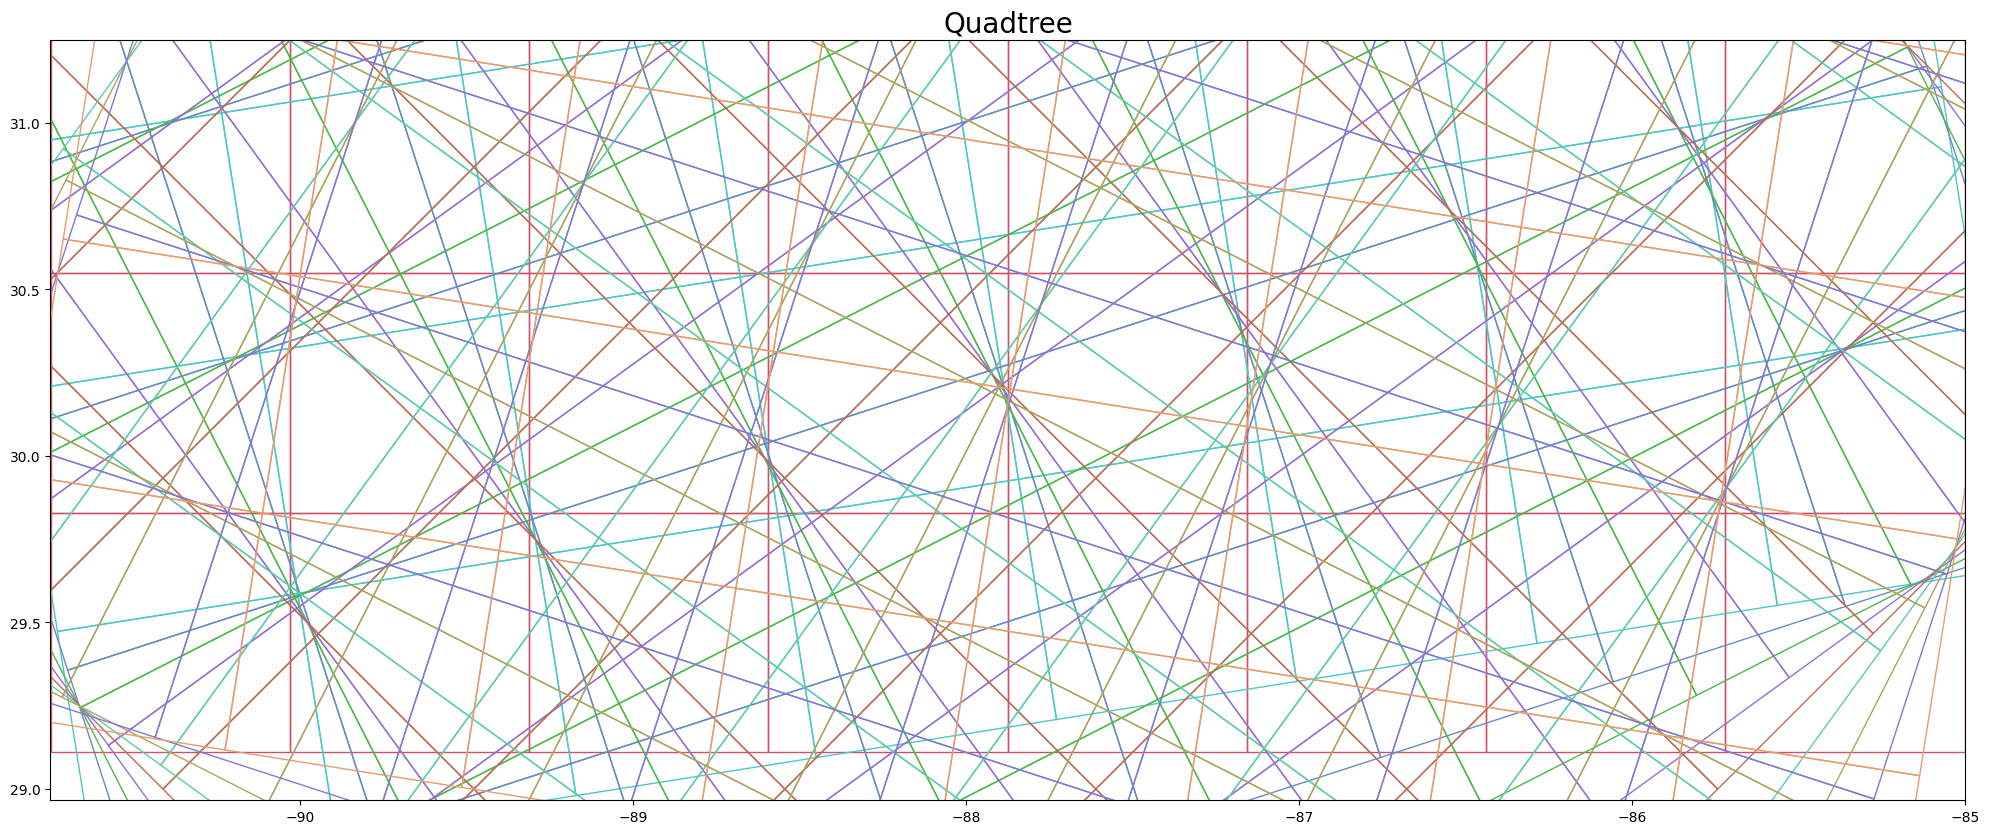

In [52]:
model2.gridding_plot

In [15]:
model2.ensemble_df

,stixel_indexes,stixel_width,stixel_height,stixel_checklist_count,stixel_calibration_point(transformed),rotation,ensemble_index,day_of_year_start,day_of_year_end,unique_stixel_id,stixel_calibration_point_transformed_left_bound,stixel_calibration_point_transformed_lower_bound,stixel_calibration_point_transformed_right_bound,stixel_calibration_point_transformed_upper_bound,calibration_point_x_jitter,calibration_point_y_jitter
0,1,0.718591,0.718591,1651,"(-86.621271, 27.140579)",0.0,0,-5.0,25.5,0_0_1,-86.621271,27.140579,-85.902680,27.859170,4.128524,-2.680989
1,3,0.718591,0.718591,936,"(-85.90268, 27.140579)",0.0,0,-5.0,25.5,0_0_3,-85.902680,27.140579,-85.184089,27.859170,4.128524,-2.680989
2,9,0.718591,0.718591,1068,"(-85.184089, 27.140579)",0.0,0,-5.0,25.5,0_0_9,-85.184089,27.140579,-84.465498,27.859170,4.128524,-2.680989
3,11,0.718591,0.718591,949,"(-84.465498, 27.140579)",0.0,0,-5.0,25.5,0_0_11,-84.465498,27.140579,-83.746907,27.859170,4.128524,-2.680989
4,14,0.718591,0.718591,673,"(-84.465498, 27.85917)",0.0,0,-5.0,25.5,0_0_14,-84.465498,27.859170,-83.746907,28.577761,4.128524,-2.680989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3392,22,0.723419,0.723419,768,"(20.559746, 96.038912)",81.0,9,346.7,377.2,9_50_22,20.559746,96.038912,21.283165,96.762331,5.189518,3.096199
3393,23,0.723419,0.723419,1230,"(20.559746, 96.762331)",81.0,9,346.7,377.2,9_50_23,20.559746,96.762331,21.283165,97.485750,5.189518,3.096199
3394,24,0.723419,0.723419,895,"(21.283165, 94.592073)",81.0,9,346.7,377.2,9_50_24,21.283165,94.592073,22.006584,95.315492,5.189518,3.096199
3395,13,0.723419,0.723419,649,"(21.328811, 93.868654)",81.0,9,353.7,384.2,9_51_13,21.328811,93.868654,22.052230,94.592073,5.189518,3.096199


In [150]:
# Convert all columns to numeric, coercing errors to NaN, then replace NaN with -1
ebird = ebird.fillna(-1)
y = ebird['observation_count'].values 
ebird_dropna = ebird.drop(['observation_count', 'locality_id', 'common_name'], axis=1)  #stemflow cannot handle character columns so remove locality_id and common_name for now
   
# Check for remaining NaN values
if ebird.isna().any().any():
    print("There are still NaN values in the DataFrame.")
else:
    print("All NaN values have been handled.")
    
# Summary of missing values
print("Summary of missing values after processing:")
print(ebird.isna().sum())


All NaN values have been handled.
Summary of missing values after processing:
locality_id                  0
latitude.x                   0
longitude.x                  0
common_name                  0
observation_count            0
species_observed             0
protocol_type                0
day_of_year                  0
time_observations_started    0
duration_minutes             0
effort_distance_km           0
number_observers             0
year                         0
barren                       0
forest                       0
fresh_marsh                  0
fresh_woody_wetland          0
grassland                    0
pasture                      0
shore                        0
shrub                        0
urban                        0
water                        0
agriculture                  0
salt_marsh                   0
salt_woody_wetland           0
ocean                        0
elevation_median             0
elevation_sd                 0
northness_median       

In [151]:
model.implement_split(ebird_dropna.reset_index(drop=True), y, verbosity=1)

Generating Ensembles: 100%|██████████| 5/5 [10:24<00:00, 124.93s/it]


Generate_Quadtree(Spatio1='longitude.x', Spatio2='latitude.x',
                  Temporal1='day_of_year',
                  base_model=Hurdle(classifier=XGBClassifier(base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=None,
                                                             device=None,
                                                             early_stopping_rounds=None,
                                                             enable_categorical=False,
                                                             eval_metric=None,
                                                             feature_types=None,
                                                             gamma=None,...
                  ensemble_fold=5, grid_len_lower_threshold=0.2,
                  grid_len_upper_threshold=2, lazy_loading=True,
                  lazy_loading_dir='stemflow_model_TGyB8tO6tNxkKXZ0',
                  min_ensemble_required=1, plot_xlims=(-90.749917, -84.9999042),
                  plot_ylims=(28.965782, 31.159047), points_lower_threshold=500,
                  random_state=42, stixel_training_size_threshold=500,
                  temporal_bin_interval=30.5, temporal_step=7)

In [19]:
from stemflow.utils.jitterrotation.jitterrotator import JitterRotator
from shapely.geometry import Polygon
import geopandas as gpd
# Remember to install shapely and geopandas if you haven't

# define a function
def geo_grid_geometry(line):
    old_x, old_y = JitterRotator.inverse_jitter_rotate(
        [line['stixel_calibration_point_transformed_left_bound'], line['stixel_calibration_point_transformed_left_bound'], line['stixel_calibration_point_transformed_right_bound'], line['stixel_calibration_point_transformed_right_bound']],
        [line['stixel_calibration_point_transformed_lower_bound'], line['stixel_calibration_point_transformed_upper_bound'], line['stixel_calibration_point_transformed_upper_bound'], line['stixel_calibration_point_transformed_lower_bound']],
        line['rotation'],
        line['calibration_point_x_jitter'],
        line['calibration_point_y_jitter'],
    )

    polygon = Polygon(list(zip(old_x, old_y)))
    return polygon

# Make a geometry attribute for each stixel
model2.ensemble_df['geometry'] = model2.ensemble_df.apply(geo_grid_geometry, axis=1)
model2.ensemble_df = gpd.GeoDataFrame(model2.ensemble_df, geometry='geometry')

In [20]:
# Assuming 'ensemble_df' is your GeoDataFrame with a 'geometry' column

# Extract bounds from geometry column
model2.ensemble_df['longitude_lower_bound'] = model2.ensemble_df.geometry.bounds.minx
model2.ensemble_df['longitude_upper_bound'] = model2.ensemble_df.geometry.bounds.maxx
model2.ensemble_df['latitude_lower_bound'] = model2.ensemble_df.geometry.bounds.miny
model2.ensemble_df['latitude_upper_bound'] = model2.ensemble_df.geometry.bounds.maxy

# Drop the original geometry column if you no longer need it
model2.ensemble_df = model2.ensemble_df.drop(columns=['geometry', 'stixel_calibration_point_transformed_left_bound','stixel_calibration_point_transformed_right_bound',
                                   'stixel_calibration_point_transformed_lower_bound', 'stixel_calibration_point_transformed_upper_bound'] )

# Display the updated DataFrame
print(model2.ensemble_df.head())


   stixel_indexes  stixel_width  stixel_height  stixel_checklist_count  \
0               1      0.718591       0.718591                    1651   
1               3      0.718591       0.718591                     936   
2               9      0.718591       0.718591                    1068   
3              11      0.718591       0.718591                     949   
4              14      0.718591       0.718591                     673   

  stixel_calibration_point(transformed)  rotation  ensemble_index  \
0               (-86.621271, 27.140579)       0.0               0   
1                (-85.90268, 27.140579)       0.0               0   
2               (-85.184089, 27.140579)       0.0               0   
3               (-84.465498, 27.140579)       0.0               0   
4                (-84.465498, 27.85917)       0.0               0   

   day_of_year_start  day_of_year_end unique_stixel_id  \
0               -5.0             25.5            0_0_1   
1               -5.0    

In [81]:
model2.ensemble_df.to_csv("generated_box_big6.csv", index=False)

In [21]:
# Split the 'unique_stixel_id' and extract the second part sliding window index(week)
model2.ensemble_df['week'] = model2.ensemble_df['unique_stixel_id'].str.split('_').str[1].astype(int)
# Subtract 1 from all values in the 'week' column
model2.ensemble_df['week'] = model2.ensemble_df['week'] + 1
# Trim rows (windows) with weeks greater than 54
model2.ensemble_df = model2.ensemble_df[model2.ensemble_df['week'] <= 53]

# Function to map week to month for 2020
def week_to_month_2020(week):
    # Define the start and end week for each month in 2020
    weeks_to_month = {
        1: (1, 5),  # January
        2: (6, 9),  # February
        3: (10, 14),  # March
        4: (15, 18),  # April
        5: (19, 22),  # May
        6: (23, 27),  # June
        7: (28, 31),  # July
        8: (32, 36),  # August
        9: (37, 40),  # September
        10: (41, 45),  # October
        11: (46, 49),  # November
        12: (50, 53),  # December
    }

    # Assign the correct month based on week
    for month, (start_week, end_week) in weeks_to_month.items():
        if start_week <= week <= end_week:
            return month
    return None  # Return None if the week doesn't match any range

# Apply the function to create a 'month' column
model2.ensemble_df['month'] = model2.ensemble_df['week'].apply(week_to_month_2020)

# Add a 'sequence' column: sequence within each 4-week group
model2.ensemble_df['sequence'] = model2.ensemble_df.groupby('month').cumcount() + 1

In [18]:
model2.ensemble_df

,stixel_indexes,stixel_width,stixel_height,stixel_checklist_count,stixel_calibration_point(transformed),rotation,ensemble_index,day_of_year_start,day_of_year_end,unique_stixel_id,stixel_calibration_point_transformed_left_bound,stixel_calibration_point_transformed_lower_bound,stixel_calibration_point_transformed_right_bound,stixel_calibration_point_transformed_upper_bound,calibration_point_x_jitter,calibration_point_y_jitter,week,month,sequence
0,1,0.718591,0.718591,1651,"(-86.621271, 27.140579)",0.0,0,-5.0,25.5,0_0_1,-86.621271,27.140579,-85.902680,27.859170,4.128524,-2.680989,1,1,1
1,3,0.718591,0.718591,936,"(-85.90268, 27.140579)",0.0,0,-5.0,25.5,0_0_3,-85.902680,27.140579,-85.184089,27.859170,4.128524,-2.680989,1,1,2
2,9,0.718591,0.718591,1068,"(-85.184089, 27.140579)",0.0,0,-5.0,25.5,0_0_9,-85.184089,27.140579,-84.465498,27.859170,4.128524,-2.680989,1,1,3
3,11,0.718591,0.718591,949,"(-84.465498, 27.140579)",0.0,0,-5.0,25.5,0_0_11,-84.465498,27.140579,-83.746907,27.859170,4.128524,-2.680989,1,1,4
4,14,0.718591,0.718591,673,"(-84.465498, 27.85917)",0.0,0,-5.0,25.5,0_0_14,-84.465498,27.859170,-83.746907,28.577761,4.128524,-2.680989,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3392,22,0.723419,0.723419,768,"(20.559746, 96.038912)",81.0,9,346.7,377.2,9_50_22,20.559746,96.038912,21.283165,96.762331,5.189518,3.096199,51,12,187
3393,23,0.723419,0.723419,1230,"(20.559746, 96.762331)",81.0,9,346.7,377.2,9_50_23,20.559746,96.762331,21.283165,97.485750,5.189518,3.096199,51,12,188
3394,24,0.723419,0.723419,895,"(21.283165, 94.592073)",81.0,9,346.7,377.2,9_50_24,21.283165,94.592073,22.006584,95.315492,5.189518,3.096199,51,12,189
3395,13,0.723419,0.723419,649,"(21.328811, 93.868654)",81.0,9,353.7,384.2,9_51_13,21.328811,93.868654,22.052230,94.592073,5.189518,3.096199,52,12,190


In [23]:
# Group by '4_week_group' and get the max of 'sequence' for each group
max_sequence_per_group = model2.ensemble_df.groupby('month')['sequence'].max()

# Convert the result to a DataFrame (optional)
max_sequence_per_group_df = max_sequence_per_group.reset_index()

# Display the result
print(max_sequence_per_group_df)


    month  sequence
0       1       348
1       2       311
2       3       398
3       4       350
4       5       281
5       6       246
6       7       161
7       8       255
8       9       234
9      10       344
10     11       274
11     12       191


In [24]:
# Select necessary columns
selected_columns = model2.ensemble_df[['sequence', 'longitude_lower_bound','longitude_upper_bound',
                                      'latitude_lower_bound', 'latitude_upper_bound', 'day_of_year_start', 'day_of_year_end']]

In [25]:
selected_columns

,sequence,longitude_lower_bound,longitude_upper_bound,latitude_lower_bound,latitude_upper_bound,day_of_year_start,day_of_year_end
0,1,-90.749795,-90.031204,29.821568,30.540159,-5.0,25.5
1,2,-90.031204,-89.312613,29.821568,30.540159,-5.0,25.5
2,3,-89.312613,-88.594022,29.821568,30.540159,-5.0,25.5
3,4,-88.594022,-87.875431,29.821568,30.540159,-5.0,25.5
4,5,-88.594022,-87.875431,30.540159,31.258750,-5.0,25.5
...,...,...,...,...,...,...,...
3392,187,-90.108513,-89.280833,29.720439,30.548119,346.7,377.2
3393,188,-90.823026,-89.995345,29.833606,30.661287,346.7,377.2
3394,189,-88.566320,-87.738639,30.208616,31.036296,346.7,377.2
3395,190,-87.844667,-87.016986,30.140532,30.968212,353.7,384.2


In [144]:
selected_columns['sequence']

0          1
1          2
2          3
3          4
4          5
        ... 
11583    738
11584    739
11585    740
11586    741
11587    742
Name: sequence, Length: 11588, dtype: int64

In [113]:
selected_columns

,sequence,longitude_lower_bound,longitude_upper_bound,latitude_lower_bound,latitude_upper_bound,day_of_year_start,day_of_year_end
0,1,-90.749795,-90.031204,29.821568,30.540159,-5.0,25.5
1,2,-90.031204,-89.312613,29.821568,30.540159,-5.0,25.5
2,3,-89.312613,-88.594022,29.821568,30.540159,-5.0,25.5
3,4,-88.594022,-87.875431,29.821568,30.540159,-5.0,25.5
4,5,-88.594022,-87.875431,30.540159,31.258750,-5.0,25.5
...,...,...,...,...,...,...,...
3392,187,-90.108513,-89.280833,29.720439,30.548119,346.7,377.2
3393,188,-90.823026,-89.995345,29.833606,30.661287,346.7,377.2
3394,189,-88.566320,-87.738639,30.208616,31.036296,346.7,377.2
3395,190,-87.844667,-87.016986,30.140532,30.968212,353.7,384.2


In [26]:
generated_box_tuple = tuple(map(tuple, selected_columns.values))


In [28]:
# Save the tuple to a .pkl file
with open('generated_box_tuple6.pkl', 'wb') as f:
    pickle.dump(generated_box_tuple, f)

In [53]:
sum_days = [0 for _ in range(13)]
months = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] 
for i in range(1, 13):
    sum_days[i] = sum_days[i - 1] + months[i]

# Initialize an empty list to store monthly DataFrames
monthly_ebird = []

# Iterate through each month and filter data
for i in range(len(sum_days) - 1):
    start_day = sum_days[i]
    end_day = sum_days[i + 1]
    
    # Filter data for the current month
    monthly_df = ebird[(ebird['day_of_year'] > start_day) & (ebird['day_of_year'] <= end_day)]
    
    # Append the filtered DataFrame to the list
    monthly_ebird.append(monthly_df)

# `monthly_data` now contains one DataFrame for each month


In [147]:
# Initialize an empty list to store monthly DataFrames
monthly_ensembles = []
for i, df in enumerate(monthly_ebird):
    model1 = Generate_Quadtree(
    base_model=Hurdle(
        classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
        regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
    ),                                      # hurdel model for zero-inflated problem (e.g., count)
    save_gridding_plot = True,
    ensemble_fold=5,                       # data are modeled 10 times, each time with jitter and rotation in Quadtree algo
    min_ensemble_required=1,                # Only points covered by > 7 ensembles will be predicted
    grid_len_upper_threshold=2,            # force splitting if the grid length exceeds 2.5
    grid_len_lower_threshold=0.2,             # stop splitting if the grid length fall short 5         
    temporal_start=sum_days[i],                       # The next 4 params define the temporal sliding window
    temporal_end=sum_days[i+1],                            
    temporal_step=7,                       # The window takes steps of 20 DOY (see AdaSTEM demo for details)
    temporal_bin_interval=30.5,               # Each window will contain data of 30.5 DOY
    points_lower_threshold=500,              # Only stixels with more than 50 samples are trained
    Spatio1='longitude.x',                    # The next three params define the name of 
    Spatio2='latitude.x',                     # spatial coordinates shown in the dataframe
    Temporal1='day_of_year',
    use_temporal_to_train=True,             # In each stixel, whether 'DOY' should be a predictor
    n_jobs=1,                               # Not using parallel computing
    random_state=42,                        # The random state makes the gridding process reproducible
    lazy_loading=True                       # Using lazy loading for large ensemble amount (e.g., >20 ensembles). 
                                            # -- Each trained ensemble will be saved into disk and will only be loaded if needed (e.g. for prediction).
    )
    y1 = df['observation_count'].values
    df = df.drop(['observation_count', 'locality_id', 'common_name'], axis=1)  #stemflow cannot handle character columns so remove locality_id and common_name for now
    
    model1.implement_split(df.reset_index(drop=True), y1, verbosity=1)
    model1.ensemble_df['month'] = i+1
    model1.ensemble_df['sequence'] = model1.ensemble_df.groupby('month').cumcount()
    # Append the filtered DataFrame to the list
    monthly_ensembles.append(model1.ensemble_df)
    # Save the plot as a PDF
    month_name = pd.Timestamp(f'2024-{i+1:02d}-01').strftime('%B')  # Get month name
    model1.gridding_plot.savefig(f'{month_name}_plot4.pdf', format='pdf')
# Combine all monthly DataFrames into a single large DataFrame
ensemble_df = pd.concat(monthly_ensembles, ignore_index=True)

Generating Ensembles: 100%|██████████| 5/5 [1:46:04<00:00, 1272.93s/it]


In [106]:
ensemble_df

,stixel_indexes,stixel_width,stixel_height,stixel_checklist_count,stixel_calibration_point(transformed),rotation,ensemble_index,day_of_year_start,day_of_year_end,unique_stixel_id,stixel_calibration_point_transformed_left_bound,stixel_calibration_point_transformed_lower_bound,stixel_calibration_point_transformed_right_bound,stixel_calibration_point_transformed_upper_bound,calibration_point_x_jitter,calibration_point_y_jitter
0,0,0.359295,0.359295,2276,"(-86.622194, 26.422587)",0.0,0,-6.1,24.9,0_0_0,-86.622194,26.422587,-86.262898,26.781883,4.127601,-2.680390
1,1,0.359295,0.359295,13410,"(-86.622194, 26.781882)",0.0,0,-6.1,24.9,0_0_1,-86.622194,26.781882,-86.262898,27.141177,4.127601,-2.680390
2,2,0.359295,0.359295,4427,"(-86.262898, 26.422587)",0.0,0,-6.1,24.9,0_0_2,-86.262898,26.422587,-85.903603,26.781883,4.127601,-2.680390
3,3,0.359295,0.359295,2930,"(-86.262898, 26.781882)",0.0,0,-6.1,24.9,0_0_3,-86.262898,26.781882,-85.903603,27.141177,4.127601,-2.680390
4,4,0.359295,0.359295,5530,"(-86.622194, 27.141178)",0.0,0,-6.1,24.9,0_0_4,-86.622194,27.141178,-86.262898,27.500473,4.127601,-2.680390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12625,38,0.711935,0.711935,1070,"(-1.931275, 90.119156)",72.0,4,358.4,389.4,4_4_38,-1.931275,90.119156,-1.219340,90.831091,-3.936320,-2.751043
12626,40,0.711935,0.711935,970,"(-2.64321, 91.543026)",72.0,4,358.4,389.4,4_4_40,-2.643210,91.543026,-1.931275,92.254961,-3.936320,-2.751043
12627,44,0.711935,0.711935,950,"(-1.21934, 87.271418)",72.0,4,358.4,389.4,4_4_44,-1.219340,87.271418,-0.507405,87.983353,-3.936320,-2.751043
12628,45,0.711935,0.711935,2150,"(-1.21934, 87.983353)",72.0,4,358.4,389.4,4_4_45,-1.219340,87.983353,-0.507405,88.695288,-3.936320,-2.751043


In [79]:
# Assuming 'ensemble_df' is your GeoDataFrame with a 'geometry' column

# Extract bounds from geometry column
ensemble_df['longitude_lower_bound'] = ensemble_df.geometry.bounds.minx
ensemble_df['longitude_upper_bound'] = ensemble_df.geometry.bounds.maxx
ensemble_df['latitude_lower_bound'] = ensemble_df.geometry.bounds.miny
ensemble_df['latitude_upper_bound'] = ensemble_df.geometry.bounds.maxy

# Drop the original geometry column if you no longer need it
ensemble_df = ensemble_df.drop(columns=['geometry', 'stixel_calibration_point_transformed_left_bound','stixel_calibration_point_transformed_right_bound',
                                   'stixel_calibration_point_transformed_lower_bound', 'stixel_calibration_point_transformed_upper_bound'] )

# Display the updated DataFrame
print(ensemble_df.head())


   stixel_indexes  stixel_width  stixel_height  stixel_checklist_count  \
0               0      0.359295       0.359295                    2276   
1               1      0.179648       0.179648                    6100   
2               2      0.179648       0.179648                    5680   
3               3      0.179648       0.179648                    1030   
4               4      0.179648       0.179648                     600   

  stixel_calibration_point(transformed)  rotation  ensemble_index  \
0               (-86.622194, 26.422587)       0.0               0   
1               (-86.622194, 26.781882)       0.0               0   
2                (-86.622194, 26.96153)       0.0               0   
3               (-86.442546, 26.781882)       0.0               0   
4                (-86.442546, 26.96153)       0.0               0   

   day_of_year_start  day_of_year_end unique_stixel_id  \
0               -6.1             24.9            0_0_0   
1               -6.1    

In [77]:
from stemflow.utils.jitterrotation.jitterrotator import JitterRotator
from shapely.geometry import Polygon
import geopandas as gpd
# Remember to install shapely and geopandas if you haven't

# define a function
def geo_grid_geometry(line):
    old_x, old_y = JitterRotator.inverse_jitter_rotate(
        [line['stixel_calibration_point_transformed_left_bound'], line['stixel_calibration_point_transformed_left_bound'], line['stixel_calibration_point_transformed_right_bound'], line['stixel_calibration_point_transformed_right_bound']],
        [line['stixel_calibration_point_transformed_lower_bound'], line['stixel_calibration_point_transformed_upper_bound'], line['stixel_calibration_point_transformed_upper_bound'], line['stixel_calibration_point_transformed_lower_bound']],
        line['rotation'],
        line['calibration_point_x_jitter'],
        line['calibration_point_y_jitter'],
    )

    polygon = Polygon(list(zip(old_x, old_y)))
    return polygon

# Make a geometry attribute for each stixel
ensemble_df['geometry'] = ensemble_df.apply(geo_grid_geometry, axis=1)
ensemble_df = gpd.GeoDataFrame(ensemble_df, geometry='geometry')

In [107]:
ensemble_df.to_csv("generated_box_small3.csv", index=False)

In [72]:
ensemble_df.to_pickle("generated_box_small1.pkl")

In [53]:
model2.gridding_plot.savefig('gridding_box_big6.pdf', format='pdf')

In [ ]:
def SAC_ensemble_training(self, index_df: pd.core.frame.DataFrame, data: pd.core.frame.DataFrame):
        """A sub-module of SAC training function.
        Train only one ensemble.

        Args:
            index_df (pd.core.frame.DataFrame): ensemble data (model.ensemble_df)
            data (pd.core.frame.DataFrame): input covariates to train
        """

        # Calculate the start indices for the sliding window

        unique_start_indices = np.sort(index_df[f"{self.Temporal1}_start"].unique())
        # training, window by window

        res_list = []
        for start in unique_start_indices:
            window_data_df = data[
                (data[self.Temporal1] >= start) & (data[self.Temporal1] < start + self.temporal_bin_interval)
            ]
            window_data_df = transform_pred_set_to_STEM_quad(self.Spatio1, self.Spatio2, window_data_df, index_df)
            window_index_df = index_df[index_df[f"{self.Temporal1}_start"] == start]

            # Merge
            def find_belonged_points(df, df_a):
                return df_a[
                    (df_a[f"{self.Spatio1}_new"] >= df["stixel_calibration_point_transformed_left_bound"].iloc[0])
                    & (df_a[f"{self.Spatio1}_new"] < df["stixel_calibration_point_transformed_right_bound"].iloc[0])
                    & (df_a[f"{self.Spatio2}_new"] >= df["stixel_calibration_point_transformed_lower_bound"].iloc[0])
                    & (df_a[f"{self.Spatio2}_new"] < df["stixel_calibration_point_transformed_upper_bound"].iloc[0])
                ]

            query_results = (
                window_index_df[
                    [
                        "ensemble_index",
                        "unique_stixel_id",
                        "stixel_calibration_point_transformed_left_bound",
                        "stixel_calibration_point_transformed_right_bound",
                        "stixel_calibration_point_transformed_lower_bound",
                        "stixel_calibration_point_transformed_upper_bound",
                    ]
                ]
                .groupby(["ensemble_index", "unique_stixel_id"])
                .apply(find_belonged_points, df_a=window_data_df)
            )

            if len(query_results) == 0:
                """All points fall out of the grids"""
                continue

            # train
            res = (
                query_results.reset_index(drop=False, level=[0, 1])
                .dropna(subset="unique_stixel_id")
                .groupby("unique_stixel_id")
                .apply(lambda stixel: self.stixel_fitting(stixel))
            ).values

            res_list.append(list(res))

        return res_list